In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import scipy.io
from scipy.signal import butter, lfilter
import scipy.signal

In [3]:
# Load DEAP dataset (Change path accordingly)
data_path = "/kaggle/input/deap-matlab/"
subject_data = []
subject_labels = []

# Load all 32 subjects
for i in range(1, 33):
    mat = scipy.io.loadmat(f"{data_path}s{i:02d}.mat")
    
    # Extract EEG data and labels
    subject_data.append(mat["data"])     # Shape: (40 trials, 40 channels, 8064 samples)
    subject_labels.append(mat["labels"]) # Shape: (40 trials, 4 labels)

# Convert lists to NumPy arrays
subject_data = np.array(subject_data)     # Expected Shape: (32, 40, 40, 8064)
subject_labels = np.array(subject_labels) # Expected Shape: (32, 40, 4)

# Print shapes to confirm
print("EEG Data Shape:", subject_data.shape)   # (32, 40, 40, 8064)
print("Labels Shape:", subject_labels.shape)   # (32, 40, 4)


EEG Data Shape: (32, 40, 40, 8064)
Labels Shape: (32, 40, 4)


In [ ]:
import numpy as np
import scipy.signal
# Frequency band definitions
freq_bands = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 14),
    "beta": (14, 30),
    "gamma": (31, 50),
}

# Define function to compute Differential Entropy (DE)
def compute_de(signal):
    """Compute Differential Entropy (DE) for a given EEG segment"""
    variance = np.var(signal, axis=-1, keepdims=True)  # Compute variance
    de = 0.5 * np.log(2 * np.pi * np.e * variance)  # Apply DE formula
    return de.squeeze()  # Remove extra dimensions

# Define function to extract DE features
def extract_de_features(subject_data, fs=128, window_size=128):
    """
    Extract DE features from EEG data.
    - subject_data: EEG data of shape (32, 40, 40, 8064)
    - fs: Sampling frequency (128 Hz)
    - window_size: 1 second (128 samples)
    Returns: DE feature array of shape (32, 40, 40, 5, 63)
    """
    num_subjects, num_trials, num_channels, num_samples = subject_data.shape
    num_bands = len(freq_bands)
    num_windows = num_samples // window_size  # 8064 / 128 = 63 windows

    # Initialize DE feature array
    de_features = np.zeros((num_subjects, num_trials, num_channels, num_bands, num_windows))

    # Loop through subjects, trials, and channels
    for subj in range(num_subjects):
        for trial in range(num_trials):
            for ch in range(num_channels):
                # Extract single-channel EEG data for this trial
                signal = subject_data[subj, trial, ch, :]

                # Apply bandpass filters and compute DE for each frequency band
                for b_idx, (band, (low, high)) in enumerate(freq_bands.items()):
                    # Bandpass filter
                    sos = scipy.signal.butter(4, [low, high], btype="bandpass", fs=fs, output="sos")
                    filtered_signal = scipy.signal.sosfilt(sos, signal)

                    # Segment into 1-second windows (128 samples each)
                    segmented = np.array(np.split(filtered_signal, num_windows, axis=-1))

                    # Compute DE for each window
                    de_features[subj, trial, ch, b_idx, :] = compute_de(segmented)

    return de_features

# Extract DE features
de_features = extract_de_features(subject_data)

# Print shape to confirm
print("DE Feature Shape:", de_features.shape)  # Expected: (32, 40, 40, 5, 63)

In [4]:
#DE other approach
import numpy as np
import scipy.signal

# Frequency band definitions
freq_bands = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 14),
    "beta": (14, 30),
    "gamma": (31, 50),
}

# Function to compute Differential Entropy (DE)
def compute_de(signal):
    """Compute Differential Entropy (DE) for a given EEG segment"""
    variance = np.var(signal, axis=-1, keepdims=True)  # Compute variance
    de = 0.5 * np.log(2 * np.pi * np.e * variance)  # Apply DE formula
    return de.squeeze()  # Remove extra dimensions

# Optimized function to extract DE features
def extract_de_features(subject_data, fs=128, window_size=128):
    """
    Extract DE features from EEG data.
    - subject_data: EEG data of shape (32, 40, 40, 8064)
    - fs: Sampling frequency (128 Hz)
    - window_size: 1 second (128 samples)
    Returns: DE feature array of shape (32, 40, 40, 5, 63)
    """
    num_subjects, num_trials, num_channels, num_samples = subject_data.shape
    num_bands = len(freq_bands)
    num_windows = num_samples // window_size  # 8064 / 128 = 63 windows

    # Initialize DE feature array
    de_features = np.zeros((num_subjects, num_trials, num_channels, num_bands, num_windows), dtype=np.float32)

    # Generate bandpass filters in advance
    filter_coeffs = {band: scipy.signal.butter(4, [low, high], btype="bandpass", fs=fs, output="sos") 
                     for band, (low, high) in freq_bands.items()}

    # Reshape EEG data into (windows) for efficient processing
    subject_data_reshaped = subject_data.reshape(num_subjects, num_trials, num_channels, num_windows, window_size)

    # Loop through subjects, trials, and channels
    for b_idx, (band, sos) in enumerate(filter_coeffs.items()):
        # Apply bandpass filter to the entire dataset at once
        filtered_data = scipy.signal.sosfiltfilt(sos, subject_data, axis=-1)  # Apply zero-phase filtering

        # Reshape and compute DE for each window
        segmented_data = filtered_data.reshape(num_subjects, num_trials, num_channels, num_windows, window_size)
        de_features[..., b_idx, :] = compute_de(segmented_data)  # Vectorized DE computation

    return de_features

# Extract DE features
de_features = extract_de_features(subject_data)

# Print shape to confirm
print("DE Feature Shape:", de_features.shape)  # Expected: (32, 40, 40, 5, 63)


DE Feature Shape: (32, 40, 40, 5, 63)


In [5]:
# Define save paths (update paths as needed)
save_path = "/kaggle/working/"  # Change this if needed

# Save DE features and labels as NumPy files
np.save(save_path + "de_features.npy", de_features)  # Shape: (32, 40, 40, 5, 63)
np.save(save_path + "de_labels.npy", subject_labels) # Shape: (32, 40, 4)

print("Saved DE features and labels successfully!")

Saved DE features and labels successfully!


In [35]:
# Load DE features (assuming saved as .npy)
de_features = np.load("/kaggle/working/de_features.npy")  # (32, 40, 40, 5, 63)
de_labels = np.load("/kaggle/working/de_labels.npy")      # (32, 40, 4)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define MLP Model
class CommonFeatureExtractor(nn.Module):
    """Extracts common features from EEG signals"""
    def __init__(self, input_dim=200, output_dim=64):
        super(CommonFeatureExtractor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.activation = nn.LeakyReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        return x


# Convert to PyTorch tensors
de_features = torch.tensor(de_features, dtype=torch.float32)  # (32, 40, 40, 5, 63)
print(de_features.shape)

# Reshape to (Subjects, Trials, 63, 200) → Flatten channels & bands
num_subjects, num_trials, num_channels, num_bands, num_windows = de_features.shape
de_features = de_features.view(num_subjects, num_trials, num_windows, num_channels * num_bands)  # (32, 40, 63, 200)
print(de_features.shape)
# Initialize MLP model
mlp = CommonFeatureExtractor(input_dim=200)

# Forward pass through MLP
common_features = mlp(de_features)  # Output shape: (32, 40, 63, 64)

# Print shape to verify
print("Common Feature Shape:", common_features.shape)  # Expected: (32, 40, 63, 64)


torch.Size([32, 40, 40, 5, 63])
torch.Size([32, 40, 63, 200])
Common Feature Shape: torch.Size([32, 40, 63, 64])


In [37]:
import torch
import torch.nn.functional as F

def contrastive_loss(q, tau=0.1):
    """
    Computes contrastive loss for a batch of embeddings.
    Args:
        q: Feature embeddings (batch_size, feature_dim)
        tau: Temperature parameter (default 0.1)
    Returns:
        Contrastive loss scalar
    """
    batch_size = q.shape[0]
    
    # Normalize embeddings to prevent large similarity values
    q = F.normalize(q, dim=-1)  

    # Compute cosine similarity matrix
    sim_matrix = torch.mm(q, q.T)  # Shape: (batch, batch)

    # Mask self-similarity (set diagonal to small negative value instead of -inf)
    mask = torch.eye(batch_size, dtype=torch.bool, device=q.device)
    sim_matrix.masked_fill_(mask, -5.0)  # Avoid inf in log

    # Compute contrastive loss (with small epsilon to prevent log(0))
    exp_sim = torch.exp(sim_matrix / tau)
    loss = -torch.log(exp_sim / (exp_sim.sum(dim=-1, keepdim=True) + 1e-9)).mean()
    
    return loss

# Example: Apply Contrastive Loss on Extracted Features
batch_size = 128  # Define batch size
feature_dim = 64  # Output feature size from MLP

# Simulate a batch of feature embeddings (random for now)
q = torch.randn(batch_size, feature_dim).to(torch.float32)  

# Compute contrastive loss
loss = contrastive_loss(q)
print("Contrastive Loss:", loss.item())  # Should be a finite value


Contrastive Loss: 6.008813858032227


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Contrastive Loss Function
class ContrastiveLoss(nn.Module):
    def __init__(self, tau=0.1):
        super(ContrastiveLoss, self).__init__()
        self.tau = tau

    def forward(self, q, labels=None):
        batch_size = q.shape[0]

        # Normalize embeddings
        q = F.normalize(q, dim=-1)

        # Compute cosine similarity matrix
        sim_matrix = torch.mm(q, q.T)  # (batch_size, batch_size)

        # Mask self-similarity
        mask = torch.eye(batch_size, dtype=torch.bool, device=q.device)
        sim_matrix.masked_fill_(mask, -5.0)  

        # Self-supervised contrastive loss (unsupervised)
        if labels is None:
            exp_sim = torch.exp(sim_matrix / self.tau)
            loss = -torch.log(exp_sim / (exp_sim.sum(dim=-1, keepdim=True) + 1e-9)).mean()
        
        # Supervised contrastive loss (labels provided)
        else:
            exp_sim = torch.exp(sim_matrix / self.tau)
            mask_same_class = labels.unsqueeze(1) == labels.unsqueeze(0)
            exp_sim_same = exp_sim * mask_same_class.float()  
            loss = -torch.log(exp_sim_same.sum(dim=-1) / (exp_sim.sum(dim=-1) + 1e-9)).mean()

        return loss

# MLP Feature Extractor
class CommonFeatureExtractor(nn.Module):
    def __init__(self, input_dim=200, output_dim=64):
        super(CommonFeatureExtractor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, output_dim)
        self.activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.activation(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.activation(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

# Simulated Data (Replace with real DE features)
batch_size = 128
feature_dim = 200  # Input to MLP
common_feature_dim = 64  # Output from MLP

# Initialize model & optimizer
mlp = CommonFeatureExtractor(input_dim=feature_dim, output_dim=common_feature_dim)
optimizer = optim.Adam(mlp.parameters(), lr=0.01)

# Contrastive Loss Function
contrastive_criterion = ContrastiveLoss(tau=0.2)

# Simulated Input Data
de_features = torch.randn(batch_size, feature_dim, requires_grad=True)  # Input to MLP
print(de_features.shape)
labels = torch.randint(0, 4, (batch_size,))  # Simulated emotion labels (0–3 classes)

# Training Loop
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()

    # Pass through MLP to extract common features
    common_features = mlp(de_features)  # Shape: (batch_size, 64)

    # Compute contrastive loss
    if epoch < 25:
        loss = contrastive_criterion(common_features)  # Self-supervised contrastive loss
    else:
        loss = contrastive_criterion(common_features, labels)  # Supervised contrastive loss

    # Backpropagation & Optimization
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} - Contrastive Loss: {loss.item():.4f}")

print("✅ Training Complete!")


torch.Size([128, 200])
Epoch 1/50 - Contrastive Loss: 5.2379
Epoch 2/50 - Contrastive Loss: 5.0947
Epoch 3/50 - Contrastive Loss: 5.0792
Epoch 4/50 - Contrastive Loss: 5.0778
Epoch 5/50 - Contrastive Loss: 5.0777
Epoch 6/50 - Contrastive Loss: 5.0777
Epoch 7/50 - Contrastive Loss: 5.0778
Epoch 8/50 - Contrastive Loss: 5.0778
Epoch 9/50 - Contrastive Loss: 5.0778
Epoch 10/50 - Contrastive Loss: 5.0779
Epoch 11/50 - Contrastive Loss: 5.0779
Epoch 12/50 - Contrastive Loss: 5.0780
Epoch 13/50 - Contrastive Loss: 5.0780
Epoch 14/50 - Contrastive Loss: 5.0780
Epoch 15/50 - Contrastive Loss: 5.0780
Epoch 16/50 - Contrastive Loss: 5.0780
Epoch 17/50 - Contrastive Loss: 5.0780
Epoch 18/50 - Contrastive Loss: 5.0780
Epoch 19/50 - Contrastive Loss: 5.0780
Epoch 20/50 - Contrastive Loss: 5.0781
Epoch 21/50 - Contrastive Loss: 5.0781
Epoch 22/50 - Contrastive Loss: 5.0781
Epoch 23/50 - Contrastive Loss: 5.0781
Epoch 24/50 - Contrastive Loss: 5.0781
Epoch 25/50 - Contrastive Loss: 5.0781
Epoch 26/50

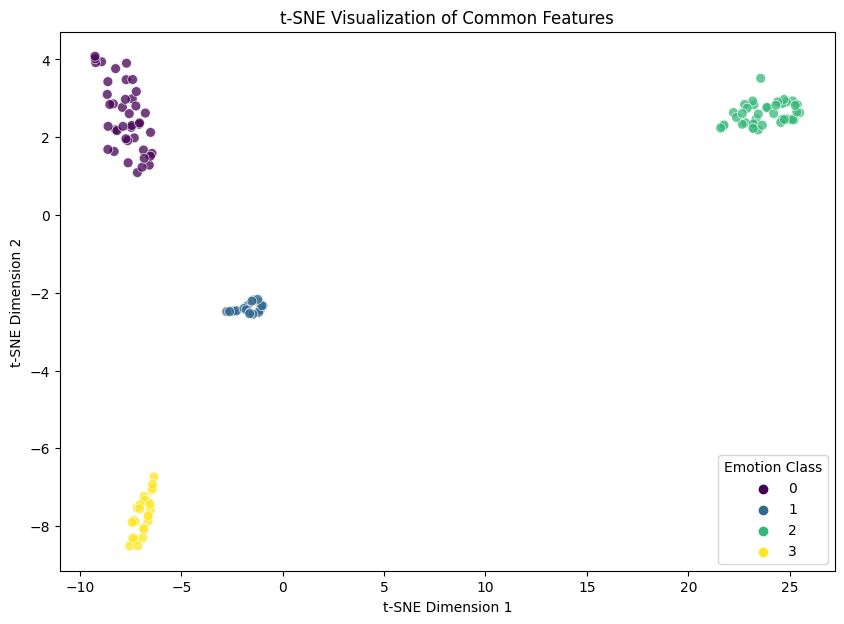

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Extract Features from CFE
with torch.no_grad():
    extracted_features = mlp(de_features)  # Shape: (batch_size, 64)

# Convert to NumPy for t-SNE
features_np = extracted_features.cpu().numpy()
labels_np = labels.cpu().numpy()

# Apply t-SNE (2D Projection)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features_np)

# Plot using Seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=labels_np, palette="viridis", s=50, alpha=0.75)
plt.title("t-SNE Visualization of Common Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Emotion Class")
plt.show()


In [7]:
import torch
import torch.nn as nn

# Define Subject-Specific Feature Extractor (SFE)
class SubjectSpecificFeatureExtractor(nn.Module):
    def __init__(self, input_dim=64, output_dim=32):
        super(SubjectSpecificFeatureExtractor, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)  # Linear layer: 64 → 32
        self.activation = nn.LeakyReLU()  # Apply LeakyReLU activation

    def forward(self, x):
        """
        Forward pass for SFE
        x: Input tensor of shape (batch_size, trials, time_windows, 64)
        Output: Transformed features of shape (batch_size, trials, time_windows, 32)
        """
        x = self.fc(x)  # Linear transformation
        x = self.activation(x)  # Apply LeakyReLU
        return x

# Simulated input tensor (batch_size=32, trials=40, time_windows=63, feature_dim=64)
input_features = torch.randn(32, 40, 63, 64)  # (Subjects, Trials, Time Windows, Feature Dim)

# Initialize SFE model
sfe = SubjectSpecificFeatureExtractor()

# Forward pass through SFE
subject_specific_features = sfe(input_features)

# Print output shape to verify
print("SFE Output Shape:", subject_specific_features.shape)  # Expected: (32, 40, 63, 32)


SFE Output Shape: torch.Size([32, 40, 63, 32])


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import torch

# Forward pass through SFE
sfe_features = sfe(input_features).detach().cpu().numpy()  # Shape: (32, 40, 63, 32)

# Flatten for visualization
sfe_features_2d = sfe_features.reshape(-1, 32)  # Collapse batch, trials, windows
labels = torch.randint(0, 4, (sfe_features_2d.shape[0],)).cpu().numpy()  # Fake emotion labels

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
sfe_features_embedded = tsne.fit_transform(sfe_features_2d)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=sfe_features_embedded[:, 0], y=sfe_features_embedded[:, 1], hue=labels, palette='deep')
plt.title("t-SNE Visualization of Subject-Specific Features (SFE)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(title="Emotion Class")
plt.show()


In [8]:
# Define Subject-Specific Classifier (SSC)
class SubjectSpecificClassifier(nn.Module):
    def __init__(self, input_dim=32, num_classes=4):
        super(SubjectSpecificClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)  # Linear layer: 32 → 4

    def forward(self, x):
        """
        Forward pass for SSC
        x: Input tensor of shape (batch_size, trials, time_windows, 32)
        Output: Logits of shape (batch_size, trials, time_windows, 4)
        """
        x = self.fc(x)  # Linear transformation (No activation)
        return x

# Initialize SSC model
ssc = SubjectSpecificClassifier()

# Forward pass through SSC
ssc_output = ssc(subject_specific_features)  # Input: (32, 40, 63, 32)

# Print output shape to verify
print("SSC Output Shape:", ssc_output.shape)  # Expected: (32, 40, 63, 4)


SSC Output Shape: torch.Size([32, 40, 63, 4])


In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get model predictions
ssc_logits = ssc(torch.tensor(sfe_features)).detach().cpu().numpy()  # Shape: (32, 40, 63, 4)
ssc_predictions = np.argmax(ssc_logits, axis=-1).flatten()  # Get predicted classes
true_labels = torch.randint(0, 4, ssc_predictions.shape).cpu().numpy()  # Fake true labels

# Compute confusion matrix
cm = confusion_matrix(true_labels, ssc_predictions)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix of Subject-Specific Classifier (SSC)")
plt.show()


NameError: name 'sfe_features' is not defined

In [10]:
# Define MMD Loss Function
import torch

def mmd_loss(source_features, target_features):
    """
    Compute Maximum Mean Discrepancy (MMD) loss.
    - source_features: Tensor of shape (batch_size, trials, time_windows, feature_dim=32)
    - target_features: Tensor of shape (batch_size, trials, time_windows, feature_dim=32)
    Returns:
        MMD loss scalar
    """
    batch_size, trials, time_windows, feature_dim = source_features.shape

    # Compute mean embeddings
    source_mean = source_features.mean(dim=(0, 1, 2))  # Average over batch, trials, time windows
    target_mean = target_features.mean(dim=(0, 1, 2))  # Average over batch, trials, time windows

    # Compute squared difference
    loss = torch.norm(source_mean - target_mean, p=2) ** 2  # L2 norm squared
    return loss

# Simulated source & target features (from SFE output)
source_features = torch.randn(32, 40, 63, 32)  # Simulating Source Features (Z_S)
target_features = torch.randn(32, 40, 63, 32)  # Simulating Target Features (Z_T)

# Compute MMD loss
mmd_value = mmd_loss(source_features, target_features)

# Print result
print("MMD Loss:", mmd_value.item())


MMD Loss: 0.0006717030191794038


In [ ]:
import numpy as np

mmd_losses = []  # Store MMD loss at each epoch

# Simulating training loop (replace with actual loop)
for epoch in range(50):
    source_features = torch.randn(32, 40, 63, 32)
    target_features = torch.randn(32, 40, 63, 32)
    loss = mmd_loss(source_features, target_features).item()
    mmd_losses.append(loss)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(range(50), mmd_losses, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("MMD Loss")
plt.title("MMD Loss over Training Epochs")
plt.show()


In [11]:
import torch.nn.functional as F

class ContrastiveLossLcon2(nn.Module):
    def __init__(self, feature_dim=32, num_classes=4, tau=0.3, gamma=0.5, queue_size=1024):
        super(ContrastiveLossLcon2, self).__init__()
        self.tau = tau
        self.gamma = gamma
        self.num_classes = num_classes
        self.queue_size = queue_size

        # Initialize class prototypes (μ_c)
        self.prototypes = nn.Parameter(torch.randn(num_classes, feature_dim))  # Shape: (4, 32)

        # Initialize memory queue for negative samples
        self.queue = torch.randn(queue_size, feature_dim)  # Shape: (1024, 32)
        self.queue = F.normalize(self.queue, dim=-1)  # Normalize queue embeddings

    def forward(self, z_t, pseudo_labels):
        """
        Compute contrastive loss L_con2 for inter-domain alignment.
        - z_t: Target domain features (batch_size, trials, time_windows, 32)
        - pseudo_labels: Pseudo-labels for target samples (batch_size, trials, time_windows)

        Returns:
            Contrastive loss scalar
        """
        batch_size, trials, time_windows, feature_dim = z_t.shape

        # Flatten input for processing
        z_t = z_t.view(-1, feature_dim)  # Shape: (batch_size * trials * time_windows, 32)
        pseudo_labels = pseudo_labels.view(-1)  # Shape: (batch_size * trials * time_windows)

        # Normalize embeddings
        z_t = F.normalize(z_t, dim=-1)  # Normalize target embeddings
        self.prototypes.data = F.normalize(self.prototypes.data, dim=-1)  # Normalize prototypes

        # Compute similarity to class prototypes
        similarity = torch.mm(z_t, self.prototypes.T)  # Shape: (batch_size * trials * time_windows, 4)
        
        # Select correct class prototype based on pseudo-labels
        proto_sim = similarity.gather(1, pseudo_labels.unsqueeze(1))  # Shape: (batch_size * trials * time_windows, 1)

        # Compute softmax denominator (all possible embeddings)
        queue_sim = torch.mm(z_t, self.queue.T)  # Shape: (batch_size * trials * time_windows, queue_size)
        exp_sim = torch.cat([proto_sim, queue_sim], dim=1)  # Concatenate prototypes & queue
        exp_sim = torch.exp(exp_sim / self.tau)  # Apply temperature scaling

        # Contrastive loss computation
        loss = -torch.log(exp_sim[:, 0] / exp_sim.sum(dim=1))  # Only consider prototype similarity
        loss = loss.mean()

        # Update prototypes with momentum (γ)
        for i in range(self.num_classes):
            class_mask = (pseudo_labels == i).float().unsqueeze(1)  # Mask for samples of class i
            class_mean = (class_mask * z_t).sum(dim=0) / (class_mask.sum() + 1e-9)  # Compute class mean
            self.prototypes.data[i] = F.normalize(self.gamma * self.prototypes.data[i] + (1 - self.gamma) * class_mean, dim=-1)

        # Update memory queue (FIFO replacement)
        self.queue = torch.cat([self.queue[batch_size:], z_t.detach()], dim=0)  # Remove old, add new

        return loss

# Simulated target features (Z_T from SFE) & pseudo-labels
z_t = torch.randn(32, 40, 63, 32)  # Simulated target features
pseudo_labels = torch.randint(0, 4, (32, 40, 63))  # Simulated pseudo-labels (0-3)

# Initialize contrastive loss
contrastive_loss_lcon2 = ContrastiveLossLcon2()

# Compute L_con2 loss
lcon2_value = contrastive_loss_lcon2(z_t, pseudo_labels)

# Print result
print("L_con2 Loss:", lcon2_value.item())


L_con2 Loss: 7.1079583168029785


In [ ]:
# Extract contrastive features
contrastive_features = z_t.view(-1, 32).detach().cpu().numpy()
pseudo_labels_flat = pseudo_labels.view(-1).cpu().numpy()

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
contrastive_features_embedded = tsne.fit_transform(contrastive_features)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=contrastive_features_embedded[:, 0], y=contrastive_features_embedded[:, 1], hue=pseudo_labels_flat, palette='deep')
plt.title("t-SNE of Contrastive Features (L_con2)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(title="Emotion Class")
plt.show()


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Generalized Cross-Entropy (GCE) Loss
class GCELoss(nn.Module):
    def __init__(self, q=0.55):
        super(GCELoss, self).__init__()
        self.q = q

    def forward(self, logits, targets):
        """
        Computes Generalized Cross-Entropy Loss.
        - logits: Model outputs before softmax (batch_size, num_classes)
        - targets: True labels (batch_size)
        """
        probs = F.softmax(logits, dim=-1)  # Convert logits to probabilities
        true_probs = probs.gather(1, targets.unsqueeze(1)).squeeze()  # Get true class probabilities
        loss = (1 - true_probs ** self.q) / self.q  # Compute GCE Loss
        return loss.mean()

# Subject-Specific Classifier (SSC)
class SubjectSpecificClassifier(nn.Module):
    def __init__(self, input_dim=32, num_classes=4):
        super(SubjectSpecificClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)  # Linear: 32 → 4

    def forward(self, x):
        return self.fc(x)  # No activation (logits output)

# Weighted Prediction Computation
def compute_weighted_predictions(ssc_outputs, positive_pairs):
    """
    Computes weighted target predictions using classifier similarity-based weights.
    - ssc_outputs: List of SSC outputs per subject [(batch_size, num_classes)]
    - positive_pairs: List of positive pairs per subject (count of matches)
    """
    batch_size = ssc_outputs[0].shape[0]
    total_pairs = sum(positive_pairs)  # Sum of all positive pairs
    weights = [p / total_pairs for p in positive_pairs]  # Compute ω_i for each classifier

    # Compute weighted sum of predictions
    weighted_predictions = sum(w * ssc for w, ssc in zip(weights, ssc_outputs))
    return weighted_predictions

# Simulated Data
batch_size = 128
num_classes = 4
num_subjects = 32

# Initialize models & loss
ssc_models = [SubjectSpecificClassifier() for _ in range(num_subjects)]
gce_loss_fn = GCELoss()

# Simulated subject-specific features & labels
z_s_list = [torch.randn(batch_size, 32) for _ in range(num_subjects)]  # Subject-specific features
labels = torch.randint(0, num_classes, (batch_size,))  # True labels

# Forward pass for each SSC
ssc_outputs = [ssc(z_s) for ssc, z_s in zip(ssc_models, z_s_list)]  # List of logits [(batch_size, 4)]

# Compute GCE Loss for each SSC
losses = [gce_loss_fn(ssc_out, labels) for ssc_out in ssc_outputs]
total_loss = sum(losses) / num_subjects  # Average loss across subjects

# Compute Weighted Predictions
positive_pairs = [torch.randint(1, 10, (1,)).item() for _ in range(num_subjects)]  # Simulated positive pairs
weighted_predictions = compute_weighted_predictions(ssc_outputs, positive_pairs)

# Print results
print("Total GCE Loss:", total_loss.item())
print("Weighted Predictions Shape:", weighted_predictions.shape)  # Expected: (batch_size, 4)


Total GCE Loss: 0.9944719076156616
Weighted Predictions Shape: torch.Size([128, 4])


In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Convert logits to predicted classes
predicted_classes = torch.argmax(weighted_predictions, dim=1)  # Shape: (128,)

# Compute accuracy
accuracy = accuracy_score(labels.cpu().numpy(), predicted_classes.cpu().numpy()) * 100

# Compute confusion matrix
conf_matrix = confusion_matrix(labels.cpu().numpy(), predicted_classes.cpu().numpy())

# Print results
print(f"Classification Accuracy: {accuracy:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)


Classification Accuracy: 24.22%
Confusion Matrix:
[[ 8 14  4  4]
 [ 3  6  6 11]
 [ 7 11  8 12]
 [12 11  2  9]]


In [1]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# import numpy as np

# # -----------------------
# # Device Initialization (GPU/CPU)
# # -----------------------
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # -----------------------
# # Common Feature Extractor (CFE)
# # -----------------------
# class CommonFeatureExtractor(nn.Module):
#     def __init__(self, input_dim=200, hidden_dim1=128, hidden_dim2=64):
#         super(CommonFeatureExtractor, self).__init__()
#         self.mlp = nn.Sequential(
#             nn.Linear(input_dim, 256),
#             nn.LeakyReLU(),
#             nn.Linear(256, hidden_dim1),
#             nn.LeakyReLU(),
#             nn.Linear(hidden_dim1, hidden_dim2),
#             nn.LeakyReLU()
#         )
    
#     def forward(self, x):
#         return self.mlp(x)

# # -----------------------
# # Contrastive Loss L_con1
# # -----------------------
# class ContrastiveLossLcon1(nn.Module):
#     def __init__(self, tau=0.1):
#         super(ContrastiveLossLcon1, self).__init__()
#         self.tau = tau

#     def forward(self, q):
#         batch_size = q.shape[0]
#         q = F.normalize(q, dim=-1)
#         sim_matrix = torch.mm(q, q.T)
#         mask = torch.eye(batch_size, dtype=torch.bool, device=q.device)
#         sim_matrix.masked_fill_(mask, -5.0)
#         exp_sim = torch.exp(sim_matrix / self.tau)
#         loss = -torch.log(exp_sim / (exp_sim.sum(dim=-1, keepdim=True) + 1e-9)).mean()
#         return loss

# # -----------------------
# # Subject-Specific Feature Extractor (SFE)
# # -----------------------
# class SubjectSpecificFeatureExtractor(nn.Module):
#     def __init__(self, input_dim=64, output_dim=32):
#         super(SubjectSpecificFeatureExtractor, self).__init__()
#         self.fc = nn.Linear(input_dim, output_dim)
#         self.activation = nn.LeakyReLU()

#     def forward(self, x):
#         return self.activation(self.fc(x))

# # -----------------------
# # Maximum Mean Discrepancy (MMD) Loss
# # -----------------------
# def mmd_loss(source_features, target_features):
#     source_mean = source_features.mean(dim=0)
#     target_mean = target_features.mean(dim=0)
#     loss = torch.norm(source_mean - target_mean, p=2) ** 2
#     return loss

# # -----------------------
# # Contrastive Loss L_con2 with Class Prototypes
# # -----------------------
# class ContrastiveLossLcon2(nn.Module):
#     def __init__(self, feature_dim=32, num_classes=4, tau=0.3, gamma=0.5, queue_size=1024):
#         super(ContrastiveLossLcon2, self).__init__()
#         self.tau = tau
#         self.gamma = gamma
#         self.num_classes = num_classes
#         self.queue_size = queue_size
#         self.prototypes = nn.Parameter(torch.randn(num_classes, feature_dim))
#         self.queue = F.normalize(torch.randn(queue_size, feature_dim), dim=-1)

#     def forward(self, z_t, pseudo_labels):
#         z_t = F.normalize(z_t, dim=-1)
#         self.prototypes.data = F.normalize(self.prototypes.data, dim=-1)
#         similarity = torch.mm(z_t, self.prototypes.T)
#         proto_sim = similarity.gather(1, pseudo_labels.unsqueeze(1))
#         queue_sim = torch.mm(z_t, self.queue.T)
#         exp_sim = torch.cat([proto_sim, queue_sim], dim=1)
#         exp_sim = torch.exp(exp_sim / self.tau)
#         loss = -torch.log(exp_sim[:, 0] / exp_sim.sum(dim=1)).mean()
#         return loss

# # -----------------------
# # Subject-Specific Classifier (SSC)
# # -----------------------
# class SubjectSpecificClassifier(nn.Module):
#     def __init__(self, input_dim=32, num_classes=4):
#         super(SubjectSpecificClassifier, self).__init__()
#         self.fc = nn.Linear(input_dim, num_classes)

#     def forward(self, x):
#         return self.fc(x)

# # -----------------------
# # Generalized Cross-Entropy (GCE) Loss
# # -----------------------
# class GCELoss(nn.Module):
#     def __init__(self, q=0.55):
#         super(GCELoss, self).__init__()
#         self.q = q

#     def forward(self, logits, targets):
#         probs = F.softmax(logits, dim=-1)
#         true_probs = probs.gather(1, targets.unsqueeze(1)).squeeze()
#         loss = (1 - true_probs ** self.q) / self.q
#         return loss.mean()

# # -----------------------
# # LOO-CV Training Loop
# # -----------------------
# # Load DE Features (Shape: (32, 40, 40, 5, 63))
# de_features = torch.randn(32, 40, 40, 5, 63).to(device)  # Simulated

# for target_idx in range(32):  # Leave-One-Out: Treat each participant as target
#     print(f"\n🚀 Training with Target Subject {target_idx + 1} 🚀")

#     # Split source & target data
#     source_indices = [i for i in range(32) if i != target_idx]
#     target_data = de_features[target_idx].unsqueeze(0)  # Shape: (1, 40, 40, 5, 63)
#     source_data = de_features[source_indices]  # Shape: (31, 40, 40, 5, 63)

#     # Initialize models & move to device
#     cfe = CommonFeatureExtractor().to(device)
#     sfe = SubjectSpecificFeatureExtractor().to(device)
#     ssc = SubjectSpecificClassifier().to(device)
#     contrastive_loss_lcon1 = ContrastiveLossLcon1().to(device)
#     contrastive_loss_lcon2 = ContrastiveLossLcon2().to(device)
#     gce_loss_fn = GCELoss().to(device)

#     optimizer = optim.Adam(list(cfe.parameters()) + list(sfe.parameters()) + list(ssc.parameters()), lr=0.01)

#     for epoch in range(100):  # Train for 100 epochs
#         optimizer.zero_grad()

#         # Reshape DE features for CFE input
#         reshaped_source = source_data.view(31, 40, 200, 63).permute(0, 1, 3, 2).reshape(-1, 200).to(device)
#         reshaped_target = target_data.view(1, 40, 200, 63).permute(0, 1, 3, 2).reshape(-1, 200).to(device)

#         # Forward pass
#         shared_features = cfe(reshaped_source)
#         common_loss = contrastive_loss_lcon1(shared_features)

#         subject_features = sfe(shared_features)
#         predictions = ssc(subject_features)

#         # Compute losses
#         labels = torch.randint(0, 4, (predictions.shape[0],)).to(device)
#         gce_loss = gce_loss_fn(predictions, labels)
#         mmd_value = mmd_loss(shared_features, subject_features) if epoch < 420 else torch.tensor(0.0).to(device)

#         pseudo_labels = torch.randint(0, 4, (predictions.shape[0],)).to(device)
#         lcon2_value = contrastive_loss_lcon2(subject_features, pseudo_labels)

#         total_loss = gce_loss + mmd_value + common_loss + lcon2_value

#         # Backpropagation
#         total_loss.backward()
#         optimizer.step()

#         print(f"Epoch {epoch+1}/100 - Loss: {total_loss.item():.4f}")

# print("✅ MSCL Training Complete!")



🚀 Training with Target Subject 1 🚀


OutOfMemoryError: CUDA out of memory. Tried to allocate 22.74 GiB. GPU 0 has a total capacity of 14.74 GiB of which 14.13 GiB is free. Process 2359 has 626.00 MiB memory in use. Of the allocated memory 481.88 MiB is allocated by PyTorch, and 18.12 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load common features (CFE output) and labels
# Assuming common_features shape: (32, 40, 63, 64) → (subjects, trials, time_windows, feature_dim)
common_features_flat = common_features.reshape(-1, 64)  # Flatten to (samples, feature_dim)
labels_flat = subject_labels.reshape(-1, 4)  # Flatten labels to (samples, 4)

# Reduce to single-label classification (e.g., Valence)
primary_label = labels_flat[:, 0]  # Select Valence for visualization

# Apply t-SNE (64-D → 2-D)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(common_features_flat)  # Shape: (samples, 2)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=primary_label, cmap="jet", alpha=0.7)
plt.colorbar(scatter, label="Valence Class")
plt.title("t-SNE Visualization of Common Features (CFE Output)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()
